In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization, Rescaling, Normalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Define the path to your dataset
path = 'animal_data/'
print(path)

animal_data/


In [5]:
# Initialize a dictionary to store image paths and labels
data = {"imgpath": [], "labels": []}

In [7]:
# List all categories (folders)
categories = os.listdir(path)

In [9]:
# Iterate over each folder and collect image paths and labels
for folder in categories:
    folderpath = os.path.join(path, folder)
    
    # Skip if it's not a directory (e.g., hidden files)
    if not os.path.isdir(folderpath):
        continue
    
    # Get list of image files in the folder
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        if fpath.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
            data["imgpath"].append(fpath.replace('\\', '/'))
            data["labels"].append(folder)

In [11]:
# Create a DataFrame to organize the data
df = pd.DataFrame(data)

In [13]:
# Initialize LabelEncoder to encode the labels
lb = LabelEncoder()

In [15]:
# Convert string labels to numeric labels
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [17]:
# Output the DataFrame to check the result
print(df.head())

                           imgpath labels  encoded_labels
0  animal_data/Bear/02sK9rlzBL.jpg   Bear               0
1  animal_data/Bear/0JODVFt5cP.jpg   Bear               0
2  animal_data/Bear/0OCqzEfbvC.jpg   Bear               0
3  animal_data/Bear/2i71I9hal8.jpg   Bear               0
4  animal_data/Bear/2WP04kThpC.jpg   Bear               0


In [19]:
# If you need to check the mapping of numeric labels to animal names:
print(lb.classes_)

['Bear' 'Cat' 'Cow' 'Deer' 'Dog' 'Dolphin' 'Elephant' 'Horse' 'Lion'
 'Panda' 'Tiger' 'Zebra']


In [21]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                              imgpath   labels
0     animal_data/Cat/hKiYraZt4W.jpeg      Cat
1      animal_data/Cat/eQSXkX9F3N.jpg      Cat
2  animal_data/Dolphin/qxq0ATtuMO.jpg  Dolphin
3     animal_data/Deer/RuiojM7vIH.jpg     Deer
4    animal_data/Zebra/X1VVkbHle5.jpg    Zebra
(842, 3)
--------Validation----------
                              imgpath   labels
0  animal_data/Dolphin/a8ngU9wjhv.jpg  Dolphin
1  animal_data/Dolphin/BHxzra3OFw.jpg  Dolphin
2    animal_data/Tiger/vNZXoTLKyL.jpg    Tiger
3     animal_data/Bear/2WP04kThpC.jpg     Bear
4  animal_data/Dolphin/uxgRwnyRQ7.jpg  Dolphin
(253, 3)
----------Test--------------
                              imgpath   labels
0  animal_data/Dolphin/VBeKMp7xYr.jpg  Dolphin
1    animal_data/Horse/yMm8VLn56O.jpg    Horse
2    animal_data/Tiger/OZBAaRGCgM.jpg    Tiger
3      animal_data/Dog/ESs1ToyxRN.jpg      Dog
4    animal_data/Panda/5Emik6umJw.jpg    Panda
(109, 3)


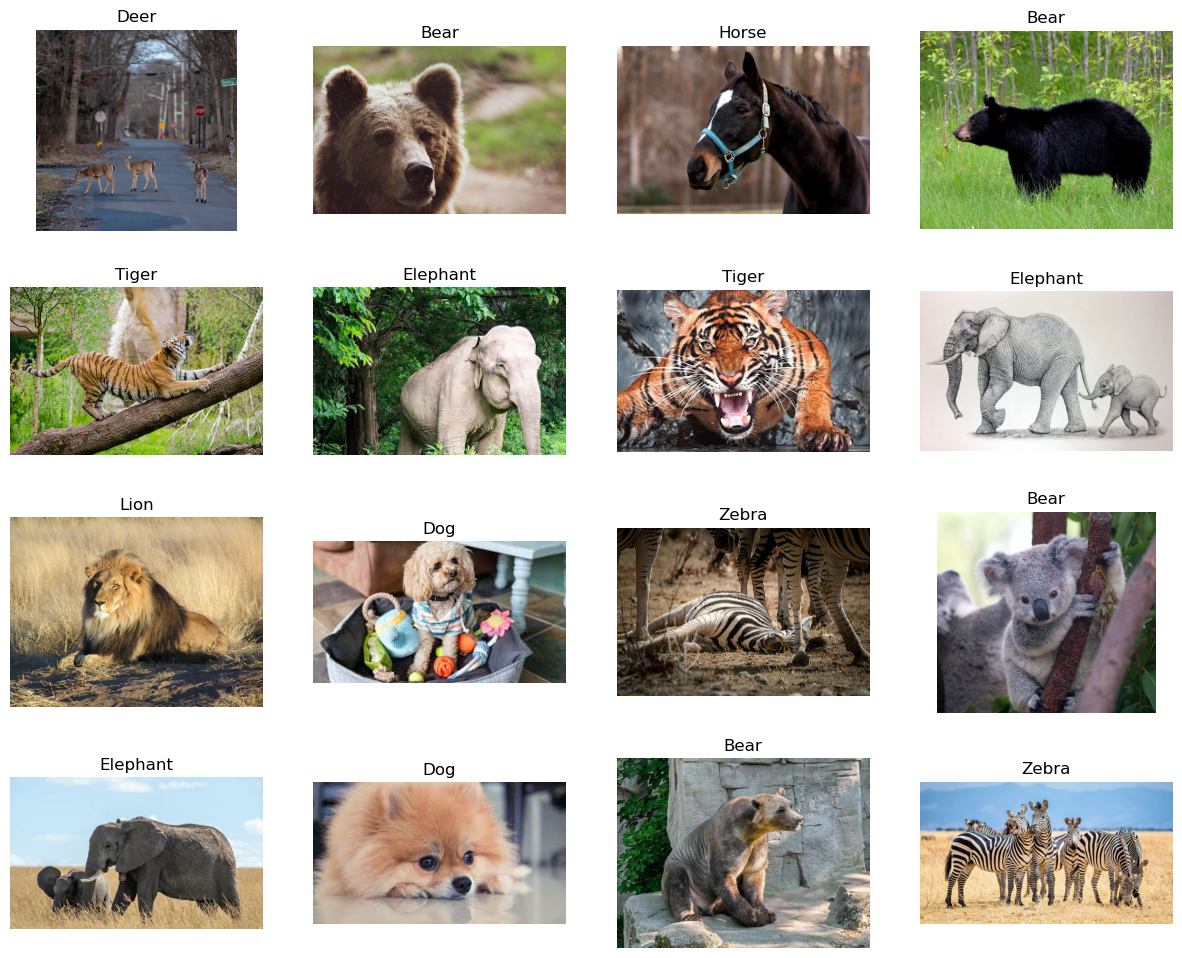

In [23]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [25]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Randomly apply shearing
    zoom_range=0.2,  # Randomly zoom in/out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 842 validated image filenames belonging to 12 classes.
Found 253 validated image filenames belonging to 12 classes.
Found 109 validated image filenames belonging to 12 classes.
CPU times: total: 78.1 ms
Wall time: 191 ms


In [27]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [28]:
num_classes = len(set(train_images.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
], name='AugmentationLayer')

inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training=False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)  # mixed_precision need separated Dense and Activation layers
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,181,115 (42.65 MB)

 Trainable params: 397,068 (1.51 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None


In [39]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save('my_model.keras')

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,181,115 (42.65 MB)

 Trainable params: 397,068 (1.51 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None
Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9704 - loss: 0.0869 - val_accuracy: 0.9921 - val_loss: 0.0380 - learning_rate: 1.0000e-05
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9646 - loss: 0.1286 - val_accuracy: 0.9921 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9685 - loss: 0.1059 - val_accuracy: 0.9921 - val_loss: 0.0381 - learning_rate: 1.0000e-05
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9655 - loss: 0.1197 - val_accuracy: 0.9921 - val_loss: 0.0382 - learning_rate: 2.0000e-06


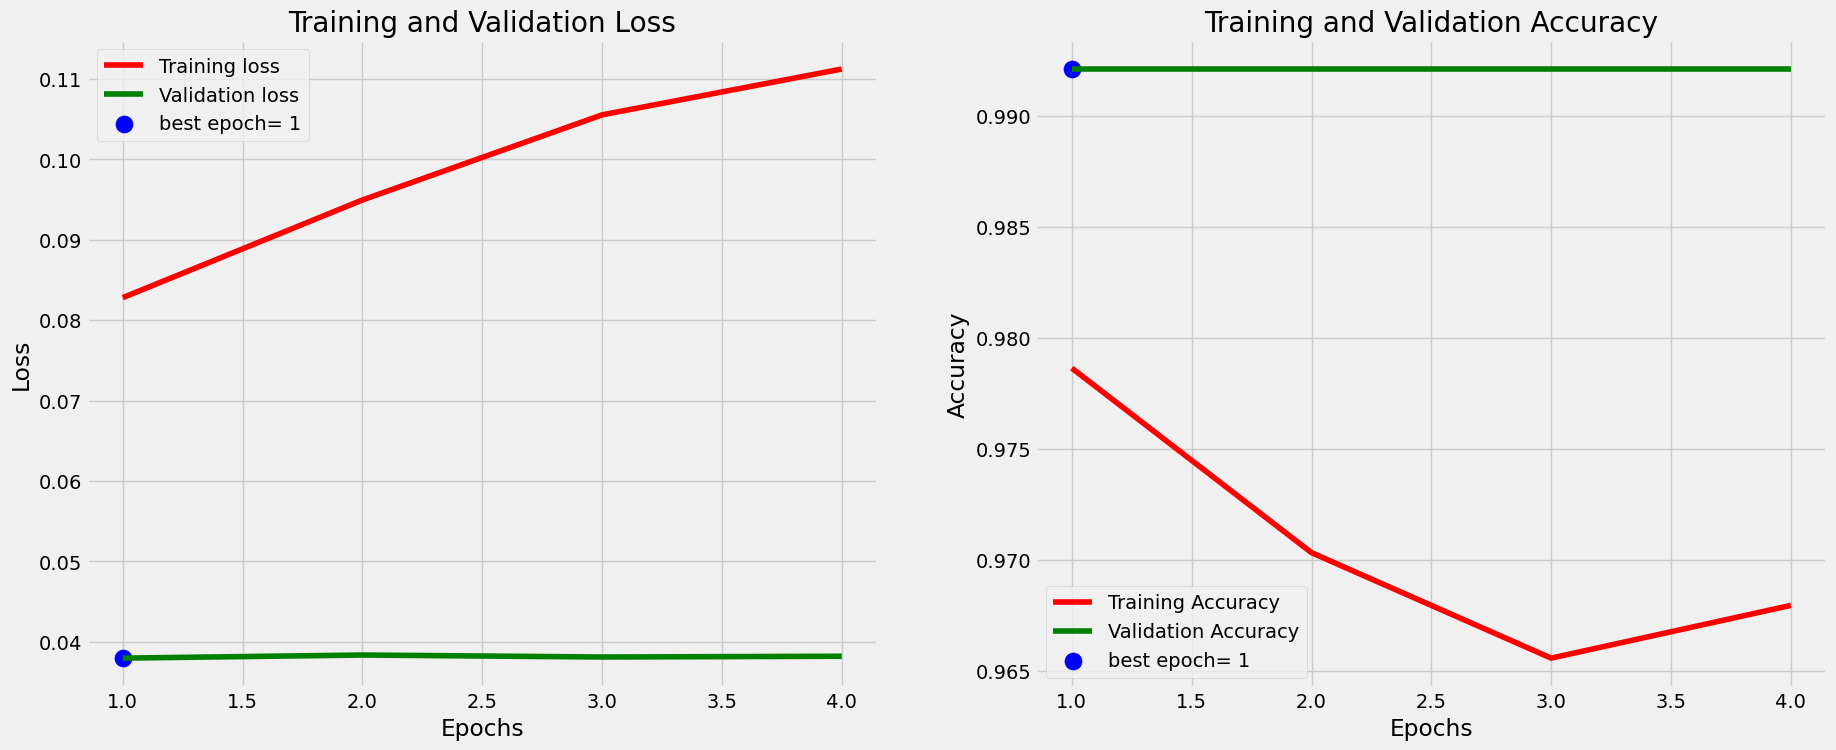

In [41]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [45]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11464
Test Accuracy: 96.33%


In [47]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
F1 Score: 0.96874883286648
              precision    recall  f1-score   support

        Bear       1.00      0.92      0.96        13
         Cat       0.88      1.00      0.93         7
         Cow       1.00      1.00      1.00         6
        Deer       1.00      1.00      1.00        11
         Dog       0.92      0.80      0.86        15
     Dolphin       1.00      1.00      1.00        10
    Elephant       1.00      1.00      1.00        10
       Horse       1.00      1.00      1.00        11
        Lion       0.88      1.00      0.93         7
       Panda       1.00      1.00      1.00         6
       Tiger       0.89      1.00      0.94         8
       Zebra       1.00      1.00      1.00         5

    accuracy                           0.96       109
   macro avg       0.96      0.98      0.97       109
weighted avg       0.97      0.96      0.96       109



In [49]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,5,Dolphin,5,Dolphin,animal_data/Dolphin/VBeKMp7xYr.jpg,0.996917
1,1,7,Horse,7,Horse,animal_data/Horse/yMm8VLn56O.jpg,0.999968
2,2,10,Tiger,10,Tiger,animal_data/Tiger/OZBAaRGCgM.jpg,0.999447
3,3,4,Dog,4,Dog,animal_data/Dog/ESs1ToyxRN.jpg,0.999845
4,4,9,Panda,9,Panda,animal_data/Panda/5Emik6umJw.jpg,0.999995
5,5,0,Bear,0,Bear,animal_data/Bear/TzCOFRj9nx.jpg,0.998684
6,6,0,Bear,0,Bear,animal_data/Bear/QMM6MT5ViN.jpeg,0.999999
7,7,5,Dolphin,5,Dolphin,animal_data/Dolphin/gIU4SDDfTw.jpg,0.999812


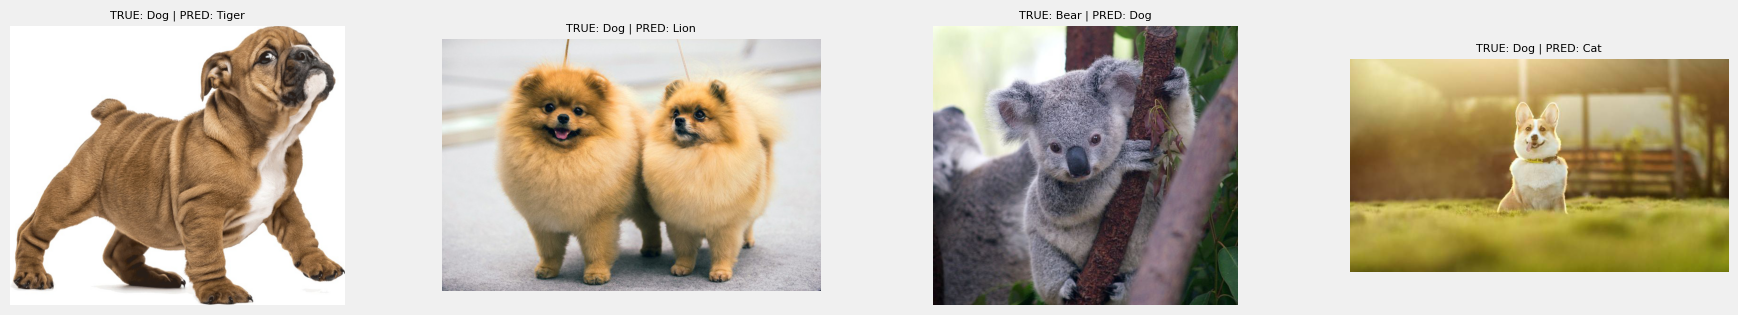

In [51]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


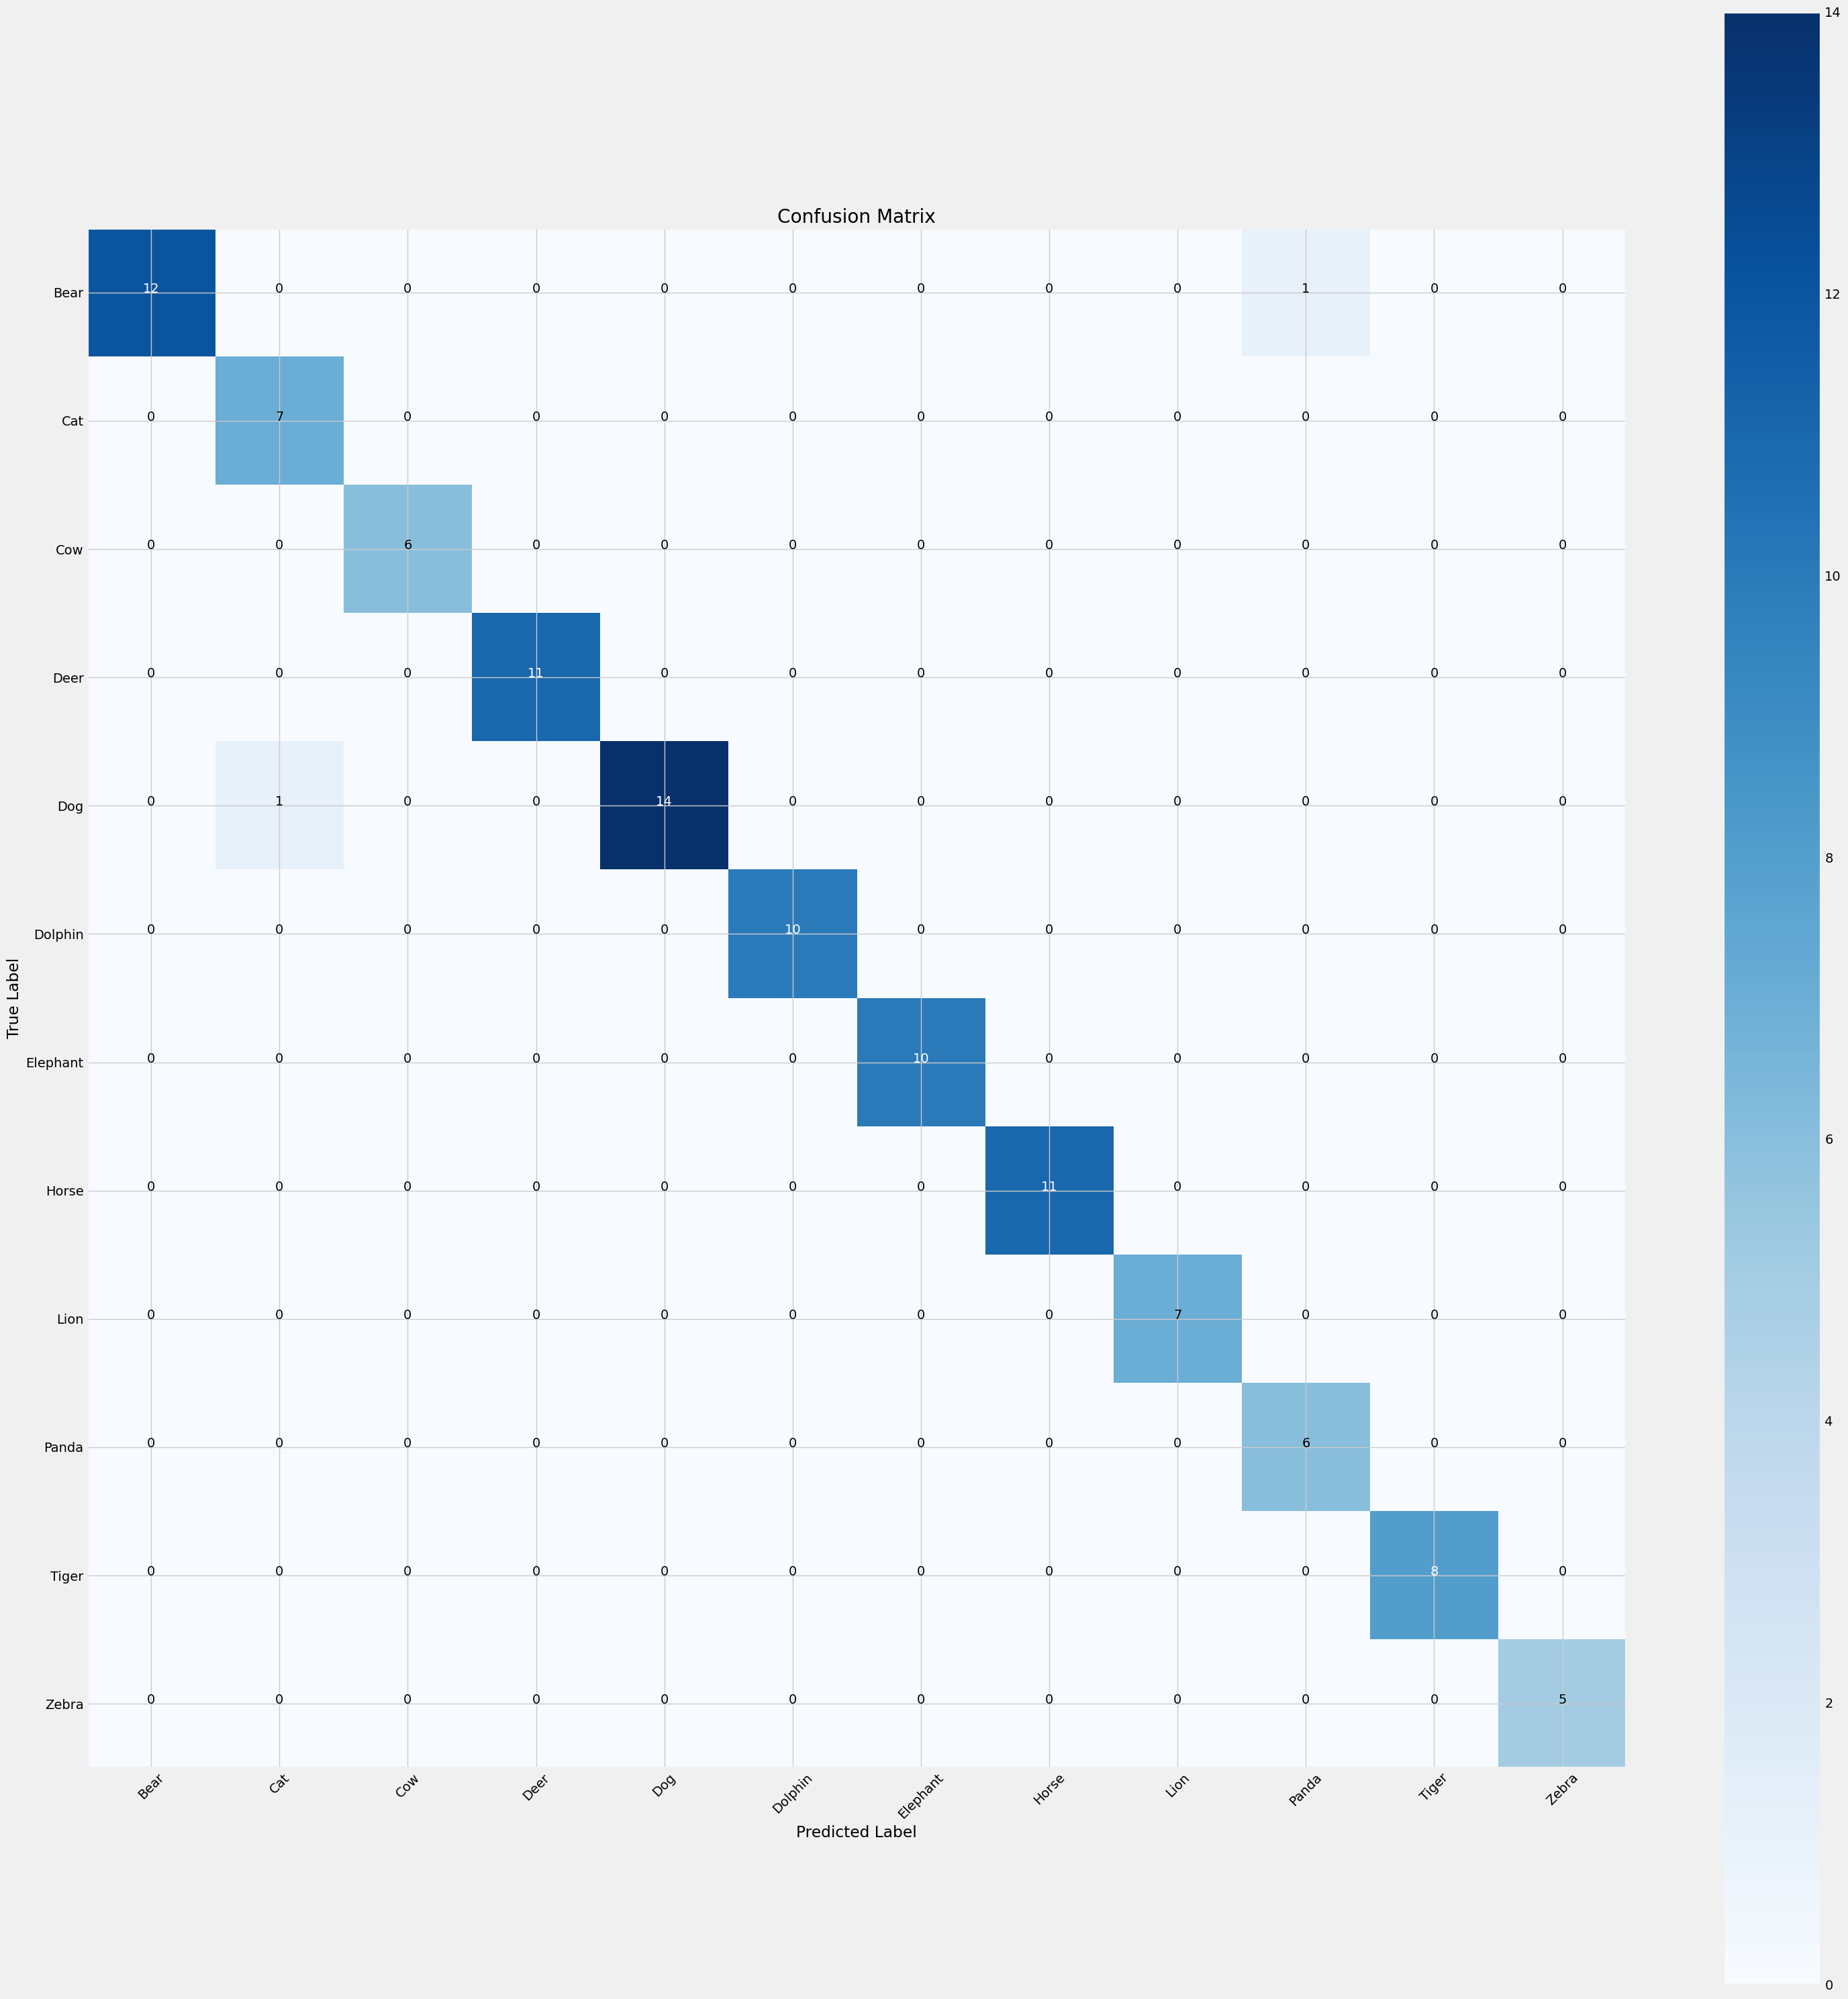

In [60]:
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')

plt.show()